# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

# Preparing Libraries, Functions, and Importing Data

## Importing libraries

In [65]:
import pandas as pd
from pandas import datetime
import numpy as np
import statsmodels
import statsmodels.api as sm
import itertools
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import warnings
import random
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

In [66]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## My Functions

### SARIMAX Forecast

In [67]:
def forecast_SARIMAX(data, order = (1,1,1), 
              seasonal_order = (0,0,0,0),
              start = '2018-04-01', 
              end = '2023-04-01',
              plot_start = '1996-04-01'):
    """Takes in zip code home value arguments to create SARIMAX summary table, 
    diagnostic graphs, and forecasting graph.
    
    Prameters:        
    
        zip: Series
            Time Series with median home values.
        
        order: tuple (optional)
            pdq for SARIMAX model.
            If empty, defaults to (1,1,1)
        
        seasonal_order: tuple (optional)
            PDQS for SARIMAX model.
            If empty, defaults to (0,0,0,0)
        
        start: string
            Beginning date for time series predictions.
            If empty, defaults to '2018-04-01'
        
        end: string
            End date for time series predictions. Note that if this date
            is beyond the end of the time series, it will create a forecast
            with confidence intervals.
            If empty, defaults to '2023-04-01'
            
        plot_start: string
            Start date for where to begin the graph on on the x axis.
            If empty, defaults to '1996-04-01'
    
    Returns:
        
        statsmodels SARIMAX summary table, diagnostic graphs, and forecasting
        graph."""
    
    # Creating a model
    model = sm.tsa.statespace.SARIMAX(data, order = order,
                                      seasonal_order = seasonal_order,
                                      enforce_stationarity = False,
                                      enforace_invertability = False)
    
    output = model.fit()
    # Print out summary table and aic score
    print(output.summary().tables[1])
    print('AIC: ', output.aic)
    
    #The prediction can be used to forecast into the future.
    prediction = output.get_prediction(start = pd.to_datetime(start),
                                       end = pd.to_datetime(end),
                                       dynamic = False)
    
    # Capturing confidence intervals
    pred_conf = prediction.conf_int()
    
    # Create diagnistic graphs
    output.plot_diagnostics(figsize = (12, 8));
    plt.show()
    
    # Create the prediction graph
    rcParams['figure.figsize'] = 12,8
    ax = data[plot_start:].plot(label = 'observed')
    
    # Plotting based on the predicted mean and filling in confidence intervals
    prediction.predicted_mean.plot(ax = ax, label = 'Forecast', alpha = .9)
    ax.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1],
                    color =  'g', alpha = .5)
    
    #Changing y limits so that the graph is in proper scale with 0 min.
    ax.set_ylim(bottom = 0)
    
    ax.legend(loc = 'upper left')
    plt.show()

### SARIMAX Train-Test

In [68]:
def train_test_SARIMAX(data, order = (1,1,1), 
              seasonal_order = (0,0,0,0),
              start = '2013-04-01', 
              end = '2018-04-01',
              plot_start = '1996-04-01'):
    """Takes in zip code home value arguments to create SARIMAX summary table, 
    diagnostic graphs, and forecasting graph.
    
    Prameters:        
    
        zip: Series
            Time Series with median home values.
        
        order: tuple (optional)
            pdq for SARIMAX model.
            If empty, defaults to (1,1,1)
        
        seasonal_order: tuple (optional)
            PDQS for SARIMAX model.
            If empty, defaults to (0,0,0,0)
        
        start: string
            Beginning date for time series predictions.
            If empty, defaults to '2018-04-01'
        
        end: string
            End date for time series predictions. Note that if this date
            is beyond the end of the time series, it will create a forecast
            with confidence intervals.
            If empty, defaults to '2023-04-01'
            
        plot_start: string
            Start date for where to begin the graph on on the x axis.
            If empty, defaults to '1996-04-01'
    
    Returns:
        
        statsmodels SARIMAX summary table, diagnostic graphs, and forecasting
        graph."""
    
    # Splitting up the data in train and test sets by date.    
    train = data[:start]
    test = data[start:]
    
#     train = data[:(int(len(data)*.80))]
#     test = data[(int(len(data)*.80)):]
    
    # Creating a model
    model = sm.tsa.statespace.SARIMAX(train, order = order,
                                      seasonal_order = seasonal_order,
                                      enforce_stationarity = False,
                                      enforace_invertability = False)
    
    output = model.fit()
    # Print out summary table and aic score
    print(output.summary().tables[1])
    print('AIC: ', output.aic)
    
    #The prediction can be used to forecast into the future.
    prediction = output.get_prediction(start = test.index[0],
                                       end = pd.to_datetime(end),
                                       dynamic = False)
    
    # Capturing confidence intervals
    pred_conf = prediction.conf_int()
    
    # Create diagnistic graphs
    output.plot_diagnostics(figsize = (12, 8));
    plt.show()
    
    # Create the prediction graph
    rcParams['figure.figsize'] = 12,8
    ax = data[plot_start:].plot(label = 'observed')
    
    # Plotting based on the predicted mean and filling in confidence intervals
    prediction.predicted_mean.plot(ax = ax, label = 'Forecast', alpha = .9)
    ax.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1],
                    color =  'g', alpha = .5)
    
    #Changing y limits so that the graph is in proper scale with 0 min.
    ax.set_ylim(bottom = 0)
    
    ax.legend(loc = 'upper left')
    plt.show()

### ARIMA Forecast

In [69]:
def forecast_ARIMA(data, order = (1,1,0),
              start = '2018-04-01', 
              forecast_length = 60):
    
    # Will need a placeholder series to build the forecast against.
    ext_dates = pd.Series(range(0,forecast_length,1), 
                          index = pd.date_range(start, 
                                                periods = forecast_length, 
                                                freq = 'MS'))
    # ARIMA doesn't like series names to be integers, so zipcodes must be 
    # changed to strings.
    data.name = str(data.name)
    
    model = statsmodels.tsa.arima_model.ARIMA(data, order=order)  
    fitted = model.fit()  
    print(fitted.summary())
    
    # Forecast
    fc, se, conf = fitted.forecast(forecast_length, alpha=0.05)

    # Make as pandas series
    fc_series = pd.Series(fc, index=ext_dates.index)
    lower_series = pd.Series(conf[:, 0], index=ext_dates.index)
    upper_series = pd.Series(conf[:, 1], index=ext_dates.index)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(data, label='training')
    plt.plot(data, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.ylim(bottom = 0)
    plt.show()

### ARIMA Train-Test

In [70]:
def train_test_ARIMA(data, order = (1,1,0),
              start = '2018-04-01'):
    
#     train = data[:(int(len(data)*.80))]
#     test = data[(int(len(data)*.80)):]
    
    # Splitting up the data in train and test sets by date.
    train = data[:start]
    test = data[start:]
    
    # ARIMA doesn't like series names to be integers, so zipcodes must be 
    # changed to strings.
    data.name = str(data.name)
    
    model = statsmodels.tsa.arima_model.ARIMA(train, order=order)  
    fitted = model.fit()  
    print(fitted.summary())

    # Forecast
    fc, se, conf = fitted.forecast(len(test), alpha=0.05)

    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(data, label='training')
    plt.plot(data, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.ylim(0)
    plt.show()

## Importing and Reviewing Data

In [71]:
zdf = pd.read_csv('zillow_data.csv')
zdf.head(1)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,498200.0,507200.0,516800.0,526300.0,535300.0,544500.0,553500.0,562400.0,571200.0,579800.0,588100.0,596300.0,604200.0,612200.0,620200.0,627700.0,634500.0,641000.0,647000.0,652700.0,658100.0,663300.0,668400.0,673400.0,678300.0,683200.0,688300.0,693300.0,698000.0,702400.0,706400.0,710200.0,714000.0,717800.0,721700.0,725700.0,729900.0,733400.0,735600.0,737200.0,739000.0,740900.0,742700.0,744400.0,746000.0,747200.0,748000.0,749000.0,750200.0,752300.0,755300.0,759200.0,764000.0,769600.0,775600.0,781900.0,787900.0,793200.0,798200.0,803100.0,807900.0,812900.0,818100.0,823100.0,828300.0,834100.0,839800.0,845600.0,851800.0,858000.0,864400.0,870700.0,876200.0,880700.0,884400.0,887600.0,890500.0,893300.0,895500.0,897300.0,899000.0,900400.0,902000.0,904400.0,907100.0,909700.0,911900.0,913000.0,913000.0,912000.0,909300.0,905300.0,901400.0,897900.0,895400.0,893600.0,891100.0,887000.0,881700.0,875900.0,870300.0,865100.0,859000.0,851500.0,843800.0,836400.0,830700.0,827300.0,824800.0,821600.0,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,780700.0,776900.0,774700.0,774200.0,774400.0,774600.0,775600.0,777800.0,775200.0,767900.0,764700.0,766100.0,764100.0,759700.0,754900.0,746200.0,737300.0,730800.0,729300.0,730200.0,730700.0,730000.0,730100.0,730100.0,731200.0,733900.0,735500.0,735400.0,734400.0,737500.0,737700.0,733700.0,734000.0,740300.0,744600.0,750500.0,760400.0,771800.0,780600.0,

In [72]:
# Find out the size so I know what I'm dealing with.
zdf.shape

(14723, 272)

In [73]:
# An example subset of a single city's zipcode.
zdf[(zdf['City'] == 'Portsmouth') & (zdf['State'] == 'NH')]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
3835,59202,3801,Portsmouth,NH,Boston,Rockingham,3836,127500.0,128100.0,128700.0,129300.0,129700.0,130100.0,130600.0,131000.0,131600.0,132300.0,133000.0,133600.0,134200.0,134900.0,135600.0,136400.0,137400.0,138400.0,139500.0,140800.0,142500.0,144300.0,146100.0,147800.0,149600.0,151300.0,153100.0,154900.0,156600.0,158300.0,160000.0,161800.0,163700.0,165800.0,167800.0,169700.0,171700.0,173700.0,175900.0,178100.0,180400.0,182800.0,185300.0,187800.0,190600.0,193400.0,196000.0,198300.0,200400.0,202200.0,203900.0,205500.0,206800.0,208100.0,209500.0,210900.0,212700.0,214700.0,216700.0,218900.0,221200.0,223600.0,226100.0,228700.0,231300.0,234000.0,236700.0,239500.0,242400.0,245200.0,247900.0,250500.0,253000.0,255500.0,257800.0,260100.0,262500.0,264800.0,267300.0,269900.0,272900.0,276100.0,279400.0,282400.0,284900.0,286900.0,288700.0,290800.0,293100.0,295900.0,298900.0,301800.0,304200.0,306000.0,307000.0,307200.0,307100.0,307100.0,307500.0,308500.0,309900.0,311900.0,314200.0,316700.0,319400.0,322400.0,326100.0,330600.0,336100.0,342200.0,348400.0,354000.0,358500.0,361600.0,363000.0,363000.0,361600.0,359500.0,357200.0,355000.0,352700.0,349700.0,345400.0,339800.0,333800.0,328400.0,324000.0,320900.0,318800.0,317400.0,316700.0,316400.0,316500.0,317400.0,319300.0,322000.0,324800.0,327300.0,329000.0,329700.0,329900.0,329900.0,329700.0,329300.0,328600.0,327700.0,326700.0,325000.0,322600.0,320400.0,318400.0,316700.0,315400.0,314400.0,313500.0,312200.0,310300.0,308000.0,306300.0,306000.0,306600.0,307000.0,306900.0,306400.0,306000.0,306100.0,306100.0,307600.0,311100.0,315200.0,317200.0,318200.0,318600.0,318800.0,319200.0,318500.0,316300.0,315000.0,314600.0,312800.0,310200.0,306200.0,302100.0,299700.0,298500.0,296300.0,295600.0,298700.0,303700.0,305700.0,305900.0,306200.0,306600.0,308900.0,312800.0,315400.0,31690

The provided heading says to filter to the chosen zipcodes. I'm actually not going to do that right now. I think I can go for broke and chase the top zips in the entire set. Wish me luck.

# Data Preprocessing

In [74]:
# def get_datetimes(df):
#     return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

The above was provided in the starter notebook and I don't know what the above was supposed to do other than confuse me, so I'm ditching it and going first for the melt, because I can't really do much with the data as it is now.

In [75]:
# I'll need to marry the metadata to the time series later on. 
zip_info = pd.DataFrame(zdf[['RegionName', 'City', 'State', 'Metro', 
                             'CountyName', 'SizeRank']])

In [76]:
zip_info = zip_info.sort_values('RegionName')

In [77]:
zip_info.head()

,RegionName,City,State,Metro,CountyName,SizeRank
5850,1001,Agawam,MA,Springfield,Hampden,5851
4199,1002,Amherst,MA,Springfield,Hampshire,4200
11213,1005,Barre,MA,Worcester,Worcester,11214
6850,1007,Belchertown,MA,Springfield,Hampshire,6851
14547,1008,Blandford,MA,Springfield,Hampden,14548


Here's where the data gets melted from wide into long format. Dates go from the rows into the columns, such that each zipcode has numerous months associated with it.

In [78]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 
                                  'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', 
                     value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [79]:
zdf_melted = melt_data(zdf)

In [80]:
zdf_melted.head(1)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0


I'm not going to do anything with that melted data for now. I actually want everything together with the time series broken out for each zipcode. That way I can have an easy-to-get column for each zip, and I can also easily put the national mean in its own column.

In [81]:
# By pivoting the data from where it is in long format, 
# I can easily get the format I want.
zdf_by_zip = zdf_melted.pivot('Month', 'RegionName', 'MeanValue')

In [82]:
zdf_by_zip.head(5)

RegionName,1001,1002,1005,1007,1008,1010,1011,1013,1020,1026,1027,1028,1030,1033,1034,1035,1036,1038,1040,1050,1053,1054,1056,1060,1062,1068,1071,1072,1073,1075,1077,1081,1082,1083,1085,1089,1092,1095,1096,1098,1104,1106,1107,1108,1109,1118,1119,1128,1129,1151,1201,1220,1223,1225,1226,1230,1235,1238,1240,1245,1247,1254,1255,1257,1262,1266,1267,1270,1301,1330,1331,1337,1338,1339,1340,1341,1344,1351,1354,1360,1364,1366,1368,1370,1373,1375,1376,1420,1430,1431,1432,1440,1450,1452,1453,1460,1462,1463,1464,1468,1469,1473,1474,1475,1501,1503,1504,1505,1506,1507,1510,1515,1516,1518,1519,1520,1521,1522,1523,1524,1527,1529,1532,1534,1535,1536,1537,1540,1541,1542,1545,1550,1560,1562,1564,1566,1568,1569,1571,1581,1583,1585,1588,1590,1602,1603,1604,1605,1606,1607,1609,1610,1611,1612,1701,1720,1730,1740,1741,1742,1746,1747,1748,1749,1752,1754,1756,1757,1760,1770,1772,1773,1775,1776,1778,1801,1803,1810,1821,1824,1826,1827,1830,1832,1833,1835,1841,1843,1844,1845,1850,1851,1852,1854,1860,1862,1863,1864,1867,1876,1879,1880,1886,1887,1890,1902,1904,1905,1906,1907,1908,1913,1915,1921,1922,1923,1930,1938,1940,1944,1945,1949,1950,1951,1952,1960,1966,1969,1970,1982,1983,1984,1985,2019,2021,2025,2026,2030,2032,2035,2038,2043,2045,2048,2050,2052,2053,2054,2056,2061,...,98277,98279,98281,98282,98284,98290,98292,98294,98295,98296,98303,98310,98311,98312,98320,98321,98327,98328,98329,98332,98333,98335,98337,98338,98339,98340,98342,98346,98349,98351,98354,98356,98358,98359,98360,98362,98363,98365,98366,98367,98368,98370,98371,98372,98373,98374,98375,98376,98380,98382,98383,98387,98388,98390,98391,98392,98394,98402,98403,98404,98405,98406,98407,98408,98409,98418,98422,98424,98443,98444,98445,98446,98465,98466,98467,98498,98499,98501,98502,98503,98506,98512,98513,98516,98520,98524,98528,98531,98532,98537,98541,98547,98550,98557,98563,98564,98568,98569,98570,98576,98579,98580,98584,98588,98589,98592,98595,98596,98597,98601,98604,98606,98607,98610,98611,98625,98626,98629,98632,98642,98645,98648,98660,98661,98662,98663,98664,98665,98671,98674,98675,98682,98683,98684,98685,98686,98801,98802,98812,98815,98822,98823,98826,98828,98837,98840,98841,98844,98847,98848,98851,98855,98856,98862,98901,98902,98903,98908,98922,98925,98926,98930,98932,98936,98937,98940,98941,98942,98944,98947,98948,98951,98953,99001,99003,99004,99005,99006,99009,99016,99019,99021,99022,99025,99026,99027,99037,99109,99110,99114,99116,99123,99141,99148,99163,99181,99201,99202,99203,99204,99205,99206,99207,99208,99212,99216,99217,99218,99223,99224,99301,99320,99323,99324,99336,99337,99338,99350,99352,99354,99361,99362,99501,99502,99503,99504,99507,99508,99515,99516,99517,99518,99567,99577,99587,99603,99611,99615,99623,99645,99654,99664,99669,99701,99705,99709,99712,99801,99835,99901
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996-04-01,113100.0,161000.0,103100.0,133400.0,117500.0,115800.0,87000.0,88500.0,97200.0,91200.0,117600.0,129100.0,121700.0,122200.0,128400.0,149900.0,135400.0,127600.0,93700.0,108100.0,141000.0,141300.0,111100.0,141100.0,127000.0,124400.0,117200.0,113300.0,142100.0,118900.0,122900.0,99900.0,105300.0,99100.0,128100.0,110000.0,99600.0,151100.0,113500.0,119900.0,65100.0,176900.0,74100.0,73300.0,60200.0,83400.0,76400.0,90800.0,87500.0,67500.0,91600.0,88600.0,97300.0,113400.0,102300.0,133900.0,99400.0,117200.0,158900.0,166700.0,81800.0,168800.0,124700.0,121000.0,163900.0,165900.0,130100.0,108600.0,100000.0,113800.0,76300.0,104800.0,94600.0,67300.0,84500.0,117900.0,83100.0,100300.0,100500.0,91900.0,79000.0,113500.0,88000.0,

Now I'm going to throw in the national average column in order to work with the national data a little bit, to establish a baseline and set initial parameters for SARIMAX.

In [83]:
zdf_by_zip['Nationwide'] = zdf_by_zip.mean(axis = 1)

# Step 3: EDA and Visualization

In [84]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

Here is just a straight up visual of the national average.

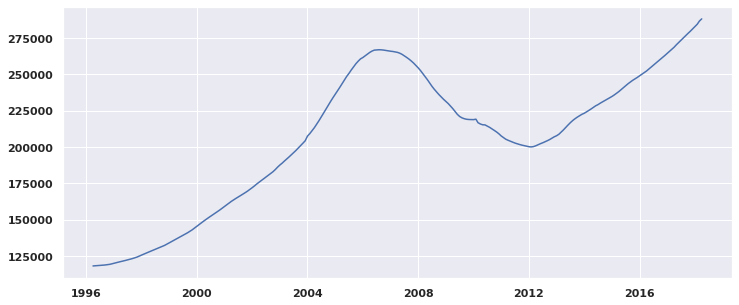

In [85]:
plt.figure(figsize = (12, 5))
plt.plot(zdf_by_zip['Nationwide']);

I'll go ahead and decompose it so I can see what the big picture looks like.

<Figure size 864x360 with 0 Axes>

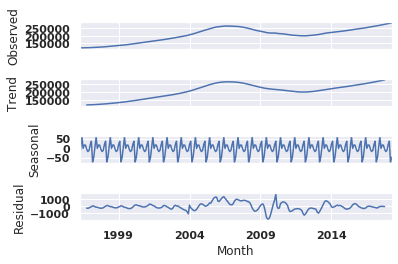

In [86]:
plt.figure(figsize = (12, 5))
fig = sm.tsa.seasonal_decompose(zdf_by_zip['Nationwide']).plot();

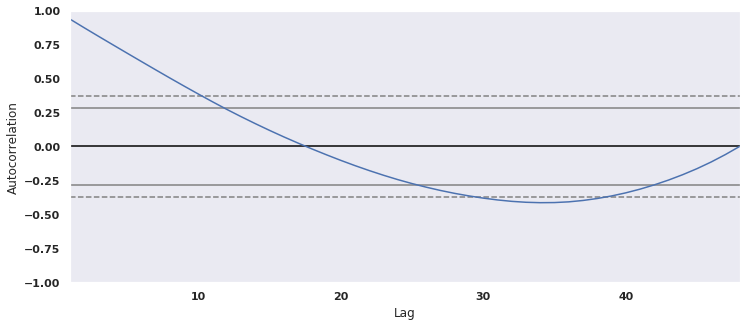

In [87]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(zdf_by_zip['Nationwide'][-48:]);

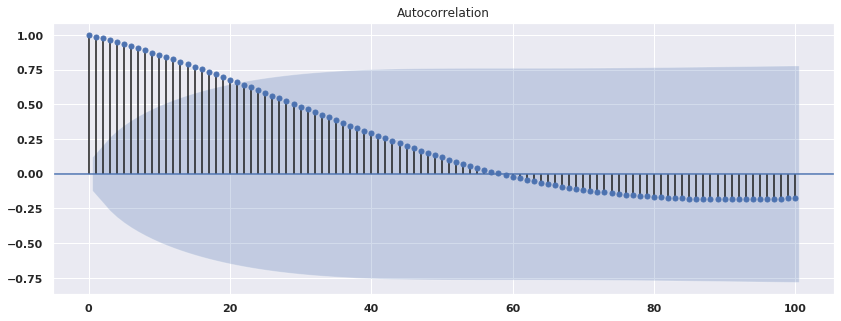

In [88]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_acf(zdf_by_zip['Nationwide'], lags = 100);

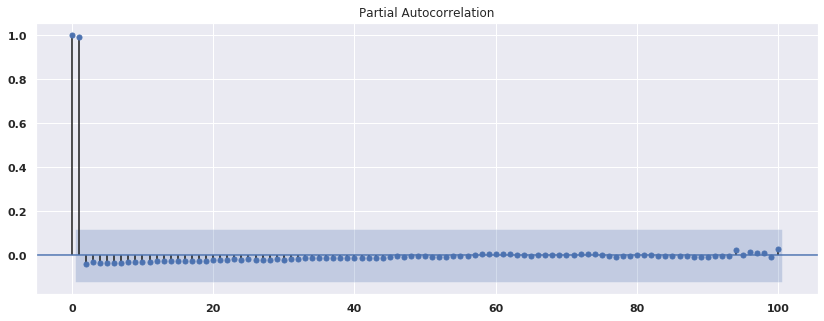

In [89]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_pacf(zdf_by_zip['Nationwide'], lags = 100);

I'll again use the example Portsmouth NH zipcode to see how one part of the picture might look on its own.

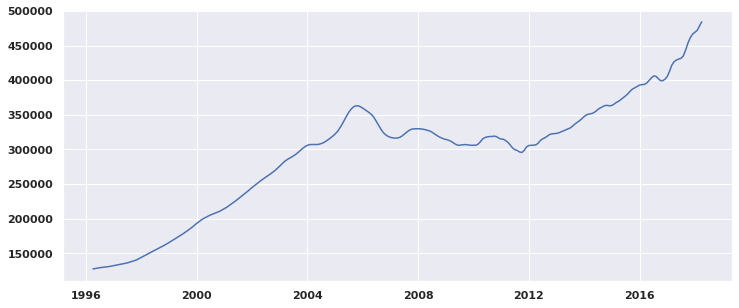

In [90]:
plt.figure(figsize = (12, 5))
plt.plot(zdf_by_zip[3801]);

<Figure size 864x360 with 0 Axes>

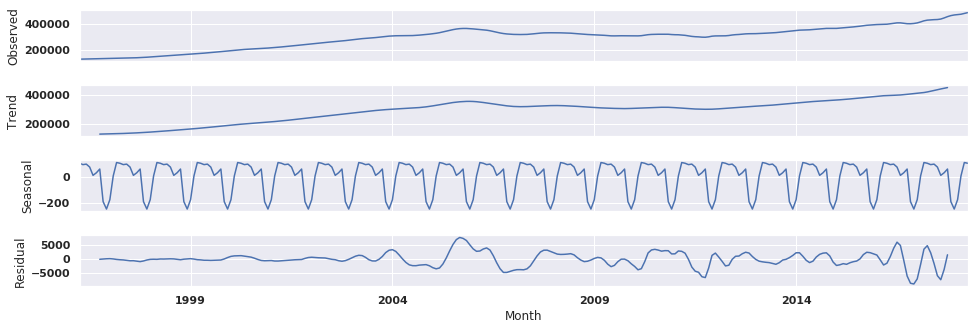

In [91]:
plt.figure(figsize = (12, 5))
sm.tsa.seasonal_decompose(zdf_by_zip[3801]).plot();

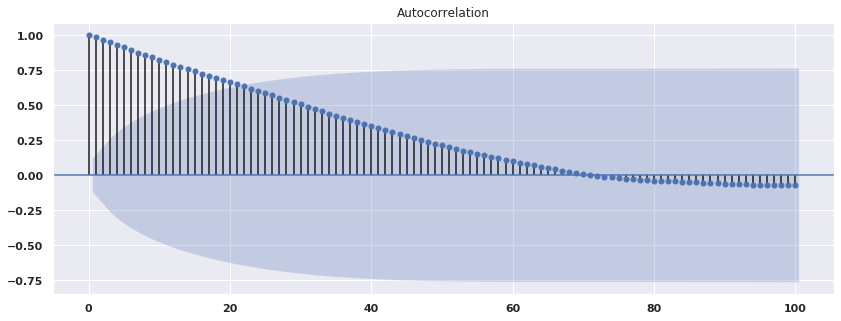

In [92]:
rcParams['figure.figsize'] = 14, 5

plot_acf(zdf_by_zip[3801], lags = 100);

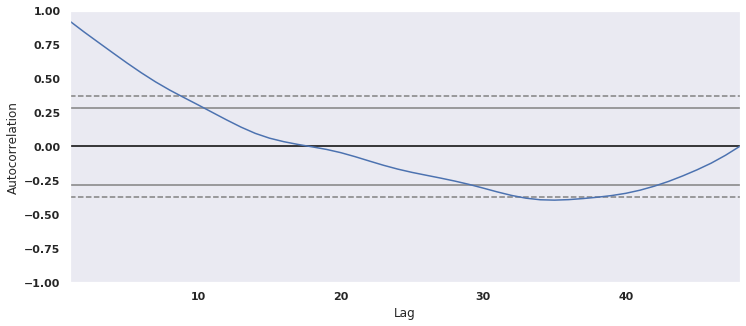

In [93]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(zdf_by_zip[3801][-48:]);

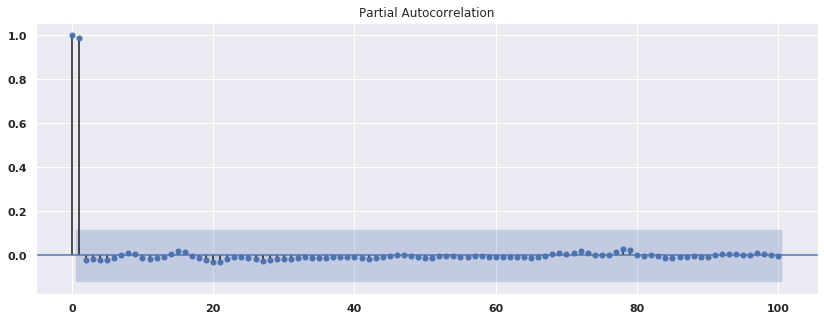

In [94]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(zdf_by_zip[3801], lags = 100);

# Step 4: Reshape from Wide to Long Format

This was done above. Leaving this here as a placeholder in case it is expected to be here.

In [95]:
# def melt_data(df):
#     melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
#     melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#     melted = melted.dropna(subset=['value'])
#     return melted.groupby('time').aggregate({'value':'mean'})

# Step 5: ARIMA Modeling

Again, starting with the national average to get a high-level overview.

I'm going to begin by iterating over models to find the version with parameters that enable the lowest aic value.

## Determining Parameters

I'll try to first find the optimal pdq and PDQS values.

A word on the results of these paramter tests. I found that the lowest AIC figures were not necessarily the best ones to use. For example, many of the restults prescribed a differencing (d) level of 2. However, upon comparing this order with others that had AIC scores nearlly as low, I found that the confidence intervals for the d = 2 orders were massively larger than some of the others.

In the end, I wound up using a catch-all for all zips of 4,1,1. This is, I'm sure, unorthodox, but upon checking not only through the national averages but through various examples, I found it to be a consistently top contender for low AIC as well as having narrow confidence intervals. Having this common set of orders also allows me to model all zip codes without spending days or weeks of computer time running through every order combination imaginable for every zipcode in the country.

### ARIMA Version

In [96]:
def aic_search(data, p_max=2, d_max=2, q_max=2, end='2018-04-01'):
    
#     train = data[:start]
#     test = data[start:]

    test_data = data[:end]
    
    #Turning the start/end dates into a forecast length.
#     forecast_len = ((pd.to_datetime(start) - pd.to_datetime(end)).days 
#                        // 365)*12
    
    forecast_len = ((pd.to_datetime('2018-04-01') - pd.to_datetime(end)).days
                    // 365)*2
    # Will need a placeholder series to build the forecast against.
#     ext_dates = pd.Series(range(0,forecast_length,1), 
#                           index = pd.date_range(start, 
#                                                 periods = forecast_length, 
#                                                 freq = 'MS'))
    
    # ARIMA doesn't like series names to be integers, so zipcodes must be 
    # changed to strings.
    data.name = str(test_data.name)
    
    # Set the ranges specified for parameters
    p = range(0,p_max)
    d = range(0,d_max)
    q = range(0,q_max)

# Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
    
    # Iterating through each of the combinations and running the model for each
    # to see which one has the lowest AIC score.

    ans = []
    ans_df = pd.DataFrame()
    rejects = []

    for comb in pdq:
        try:
            # create and fit the model
            model = statsmodels.tsa.arima_model.ARIMA(test_data, 
                                                      order=(comb)) 
            fitted = model.fit()

            # Add the newest combination to the ans list
            ans.append([comb, fitted.aic])

            # Create the variables for forecast, confidence intervals, and
            # whatever the hell se is.
            fc, se, conf = fitted.forecast(forecast_len, alpha=0.05)

            i = forecast_len - 1
            fc = round(fc[i],1)
            interval_size = round(conf[i,1] - conf[i,0],0)
            df_data = [[comb, fitted.aic, interval_size, fc]]
            columns = ['Orders', 'AIC', 'IntervalSize', 'forecasted_value']

            # Fill the array with AIC results and the dataframe with additional info
            temp_df = pd.DataFrame(data = df_data, columns = columns)
            ans_df = pd.concat([ans_df, temp_df])

        except:
            # If any combination fails, we probably want to know about it so 
            # we can potentially correct the problem and re-try. It might be 
            # the winner.
            rejects.append(comb)
#         print('Combination {} failed.'.format(comb))
            continue
    
    ans_df = ans_df.sort_values('AIC', ascending = True)
    ans.sort(key = lambda x: x[1], reverse = False)
    return ans, ans_df, rejects

In [97]:
# order_list, order_df, fails = aic_search(zdf_by_zip[33037], 
#                                   p_max=4, d_max=3, q_max=4, 
#                                   end='2013-04-01')

In [98]:
# order_list = [x[0] for x in order_list]

In [99]:
# order_list[:8]

In [100]:
#Generate a list of all zips and select a sample of 50.
zip_list = zdf_by_zip.columns
random_zips = np.random.choice(zip_list, 25)
# new_zips = []
# for this_zip in random_zips:
#     new_zips.append(this_zip)
# random_zips = list(random_zips)
zip_dict = dict()
univ_list = []

So the below is the weirdest thing I've ever seen before. There was something about putting in the numbers from the random choice generater that caused the d value to fail for all 1 values. You heard me -- totally unrelated things. If I put in the choice manually, it worked. If I let it be randomly generated, it didn't. 

However! If I re-ran the loop without re-running the random generator, it worked just fine. 

So I found that if I put in a buffer cell to run code in the middle, I can use it.

Shake my head.

In [101]:
for azip in random_zips:
#     try: 
        # Running the aic_search function that will populate the dictionary
        # with the top ten order combinations for each selected zip.
#     print(azip)
    univ_list, order_df, fails = aic_search(zdf_by_zip[azip], p_max = 2,
                                            d_max = 2,  
                                            q_max = 2,
                                            end = '2017-04-01')
    
#     univ_list = [x[0] for x in univ_list]
#     zip_dict[azip] = univ_list[:30]
    
#     except:
#         print('Something went horribly wrong!')
#         continue

In [102]:
for azip in random_zips:
#     try: 
        # Running the aic_search function that will populate the dictionary
        # with the top ten order combinations for each selected zip.
#     print(azip)
    univ_list, order_df, fails = aic_search(zdf_by_zip[azip], p_max = 4, 
                                            d_max = 2, 
                                            q_max = 4,
                                            end = '2017-04-01')
    
#     order_list, order_df, fails = aic_search(zdf_by_zip[33037], 
#                                   p_max=4, d_max=3, q_max=4, 
#                                   end='2013-04-01')
    
    univ_list = [x[0] for x in univ_list]
    if len(univ_list) >= 10:
        zip_dict[azip] = univ_list[:10]
    
#     except:
#         print('Something went horribly wrong!')
#         continue

In [103]:
comb_list = []

start = 0
for v in zip_dict.values():
    print(comb_list)
    if start == 0:
        comb_list = v.copy()
#         print(2)
        start = 1
    for i in comb_list:
#         print(3)
        if i in v:
#             print(4)
            continue
        else:
            comb_list.remove(i)
#             print(5)
            continue

[]
[(3, 1, 2), (3, 1, 3), (2, 1, 3), (1, 1, 3), (3, 1, 1), (1, 1, 1), (1, 1, 2), (2, 1, 1), (2, 1, 2), (3, 0, 3)]
[(3, 1, 2), (3, 1, 3), (2, 1, 3), (1, 1, 3), (3, 1, 1), (1, 1, 2), (2, 1, 2), (3, 0, 3)]
[(3, 1, 2), (3, 1, 3), (2, 1, 3), (1, 1, 3), (3, 1, 1), (1, 1, 2), (2, 1, 2), (3, 0, 3)]
[(3, 1, 2), (3, 1, 3), (2, 1, 3), (1, 1, 3), (3, 1, 1), (1, 1, 2), (2, 1, 2)]
[(3, 1, 2), (3, 1, 3), (2, 1, 3), (1, 1, 3), (3, 1, 1), (1, 1, 2), (2, 1, 2)]
[(3, 1, 2), (3, 1, 3), (2, 1, 3), (1, 1, 3), (3, 1, 1), (1, 1, 2)]
[(3, 1, 2), (3, 1, 3), (2, 1, 3), (1, 1, 3), (3, 1, 1)]
[(3, 1, 2), (3, 1, 3), (2, 1, 3), (1, 1, 3), (3, 1, 1)]
[(3, 1, 2), (3, 1, 3), (2, 1, 3), (1, 1, 3), (3, 1, 1)]
[(3, 1, 2), (3, 1, 3), (2, 1, 3), (1, 1, 3), (3, 1, 1)]
[(3, 1, 2), (3, 1, 3), (2, 1, 3), (1, 1, 3), (3, 1, 1)]
[(3, 1, 2), (2, 1, 3), (1, 1, 3), (3, 1, 1)]
[(2, 1, 3), (1, 1, 3), (3, 1, 1)]
[(2, 1, 3), (1, 1, 3), (3, 1, 1)]
[(2, 1, 3), (1, 1, 3), (3, 1, 1)]
[(2, 1, 3), (1, 1, 3), (3, 1, 1)]
[(2, 1, 3), (1, 1, 3), (

In [104]:
comb_list

[(2, 1, 3), (1, 1, 3), (3, 1, 1)]

In [105]:
order_df

,Orders,AIC,IntervalSize,forecasted_value
0,"(3, 1, 2)",3782.399638,4743.0,177496.7
0,"(3, 1, 3)",3784.383864,4746.0,177482.5
0,"(2, 1, 3)",3786.712787,4787.0,177753.3
0,"(1, 1, 3)",3786.937159,4877.0,177995.8
0,"(2, 1, 2)",3795.814842,5011.0,177385.6
0,"(2, 0, 3)",3808.709223,4819.0,177788.4
0,"(3, 0, 3)",3808.872322,4738.0,177535.6
0,"(3, 1, 1)",3813.068360,4889.0,178092.8
0,"(1, 1, 2)",3818.345954,5443.0,177748.0
0,"(1, 1, 1)",3820.299141,4920.0,177799.1


In [106]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(0,5)
d = range(0,2)
q = range(0,3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
# PDQS = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [107]:

## Commenting out to keep it from running when I run cells, since it takes
## so long to compute.

# Iterating through each of the combinations and running the model for each
# to see which one has the lowest AIC score.

ans = []
ans_df = pd.DataFrame()

for comb in pdq:
    try:
    #         print(comb)
        model = statsmodels.tsa.arima_model.ARIMA(zdf_by_zip['Nationwide'], 
                                                  order=(comb)) 
        fitted = model.fit()
    #         print(fitted.aic)
    #         print(fitted.summary())
        ans.append([comb, fitted.aic])
    #         print('ARIMA {} x : AIC Calculated = {}'
    #               .format(comb, model.aic))
        fc, se, conf = fitted.forecast(120, alpha=0.05)
    #     print('Confidence Interval Delta: {}'.format(
    #         round(conf[119,1] - conf[119,0],0)))

        fc = round(fc[119],1)
        interval_size = round(conf[119,1] - conf[119,0],0)
        data = [[comb, fitted.aic, interval_size, fc]]
        columns = ['Orders', 'AIC', 'IntervalSize', 'forecasted_value']

        temp_df = pd.DataFrame(data = data, columns = columns)
        ans_df = pd.concat([ans_df, temp_df])


    except:
        # If any combination fails, we probably want to know about it so 
        # we can potentially correct the problem and re-try. It might be 
        # the winner.
        print('Combination {} failed.'.format(comb))
        continue

Combination (0, 0, 2) failed.
Combination (2, 1, 2) failed.
Combination (3, 0, 2) failed.


In [108]:
ans

[[(0, 0, 0), 6465.773418952258],
 [(0, 0, 1), 6109.709276331871],
 [(0, 1, 0), 4467.706878938894],
 [(0, 1, 1), 4217.013426579215],
 [(0, 1, 2), 4044.6139217534214],
 [(1, 0, 0), 4570.66995319641],
 [(1, 0, 1), 4307.869141361881],
 [(1, 0, 2), 4120.9756455763345],
 [(1, 1, 0), 3738.5373266397373],
 [(1, 1, 1), 3723.3204729020367],
 [(1, 1, 2), 3724.8898195968386],
 [(2, 0, 0), 3765.982892618976],
 [(2, 0, 1), 3748.511870931876],
 [(2, 0, 2), 3750.3014175169706],
 [(2, 1, 0), 3722.673661401792],
 [(2, 1, 1), 3724.6700310593274],
 [(3, 0, 0), 3748.4178754446393],
 [(3, 0, 1), 3750.26047546664],
 [(3, 1, 0), 3724.672139068409],
 [(3, 1, 1), 3725.4897368073584],
 [(3, 1, 2), 3726.7855996726576],
 [(4, 0, 0), 3750.407490430642],
 [(4, 0, 1), 3751.3771798478606],
 [(4, 0, 2), 3752.0731776421467],
 [(4, 1, 0), 3725.118712639551],
 [(4, 1, 1), 3726.410950264635],
 [(4, 1, 2), 3728.2724523690595]]

In [109]:
ans.sort(key = lambda x: x[1], reverse = False)

In [110]:
ans = ans.sort(key = lambda x: x[1], reverse = False)

In [111]:
ans

In [112]:
ans_df.sort_values('AIC', ascending = True)

,Orders,AIC,IntervalSize,forecasted_value
0,"(2, 1, 0)",3722.673661,313866.0,415418.1
0,"(1, 1, 1)",3723.320473,314581.0,419214.9
0,"(2, 1, 1)",3724.670031,314017.0,415553.5
0,"(3, 1, 0)",3724.672139,313930.0,415358.0
0,"(1, 1, 2)",3724.889820,314436.0,417030.0
0,"(4, 1, 0)",3725.118713,314425.0,420412.3
0,"(3, 1, 1)",3725.489737,313124.0,413349.3
0,"(4, 1, 1)",3726.410950,314499.0,418991.3
0,"(3, 1, 2)",3726.785600,314387.0,417863.3
0,"(4, 1, 2)",3728.272452,314080.0,415980.2


This should provide the combination with the lowest AIC score.

### SARIMAX Version Without Seasons

In [113]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(0,8)
d = range(0,3)
q = range(0,5)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
# PDQS = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [114]:
## Commenting out to keep it from running when I run cells, since it takes
## so long to compute.

# Iterating through each of the combinations and running the model for each
# to see which one has the lowest AIC score.

# ans = []
# for comb in pdq:
#     try:
#         model = sm.tsa.statespace.SARIMAX(zdf_by_zip[3801],
#                                           order = comb,
#                                           seasonal_order = (0,0,0,0),
#                                           enforce_stationarity = False,
#                                           envorce_invertibility = False)
#         output = model.fit()
#         ans.append([comb, output.aic])
#         print('ARIMA {} x : AIC Calculated = {}'
#               .format(comb, output.aic))
#     except:
#         # If any combination fails, we probably want to know about it so 
#         # we can potentially correct the problem and re-try. It might be 
#         # the winner.
#         print('Combination {} {} failed.'.format(comb, combs))
#         continue

In [115]:
# ans.sort(key = lambda x: x[1], reverse = False)

This should provide the combination with the lowest AIC score.

In [116]:
# ans[0]

### SARIMAX with seasons version

In [117]:
# # Define the p, d and q parameters to take any value between 0 and 2
# p = d = q = range(0, 5)

# # Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, 1, q))

# # Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
# PDQS = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [118]:
## Commenting out to keep it from running when I run cells, since it takes
## so long to compute.

# Iterating through each of the combinations and running the model for each
# to see which one has the lowest AIC score.

# ans = []
# for comb in pdq:
#     for combs in PDQS:
#         try:
#             model = sm.tsa.statespace.SARIMAX(zdf_by_zip['Nationwide'],
#                                               order = comb,
#                                               seasonal_order = (combs),
#                                               enforce_stationarity = False,
#                                               envorce_invertibility = False)
#             output = model.fit()
#             ans.append([comb, combs, output.aic])
#             print('ARIMA {} x {}12 : AIC Calculated = {}'
#                   .format(comb, combs, output.aic))
#         except:
#             # If any combination fails, we probably want to know about it so 
#             # we can potentially correct the problem and re-try. It might be 
#             # the winner.
#             print('Combination {} {} failed.'.format(comb, combs))
#             continue

In [119]:
# ans.sort(key = lambda x: x[2], reverse = False)

This should provide the combination with the lowest AIC score.

In [120]:
# ans[0]

A d score of two for both seasonal and non-seasonal. That's weird. I wound up playing with several different iterations, and I came up with the below combination as the best balance between AIC and the smallest margin of error. This was done largely by graphing and re-graphing, and finding the shape that seemed to make the most sense, while maintaining a competitively low AIC.

## Preliminary Tests and Forecasts

### SARIMAX Modeling

#### SARIMAX Nationwide Test

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.1455      0.729      2.945      0.003       0.717       3.574
ar.L2         -1.6695      1.274     -1.310      0.190      -4.167       0.828
ar.L3          0.4132      1.180      0.350      0.726      -1.900       2.726
ar.L4          0.1197      0.376      0.318      0.750      -0.617       0.856
ar.L5         -0.0844      0.266     -0.318      0.751      -0.605       0.437
ar.L6          0.0323      0.116      0.278      0.781      -0.195       0.260
ma.L1         -2.4675      0.729     -3.385      0.001      -3.896      -1.039
ma.L2          2.3996      1.447      1.658      0.097      -0.437       5.236
ma.L3         -1.0863      1.497     -0.725      0.468      -4.021       1.849
ma.L4          0.2048      0.665      0.308      0.758      -1.099       1.508
sigma2      9.496e+04   5310.106     17.883      0.0

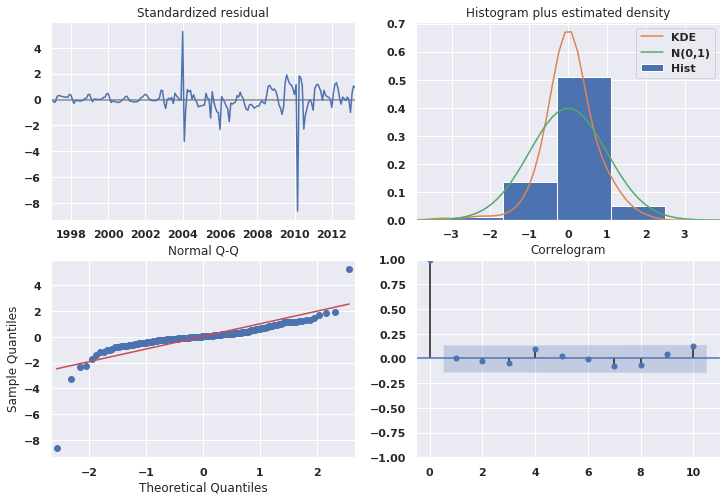

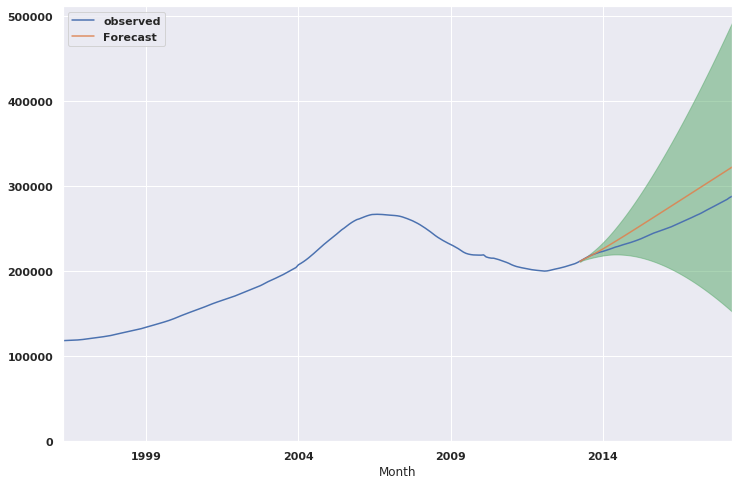

In [121]:
train_test_SARIMAX(zdf_by_zip['Nationwide'],
                   order = (6,2,4),
                   start = '2013-04-01')

#### SARIMAX Example Test

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6320      0.042     38.972      0.000       1.550       1.714
ar.L2         -1.0633      0.059    -18.035      0.000      -1.179      -0.948
ar.L3          0.3826      0.034     11.352      0.000       0.317       0.449
sigma2      3.403e+05   2.11e+04     16.161      0.000    2.99e+05    3.82e+05
AIC:  3138.664643826548


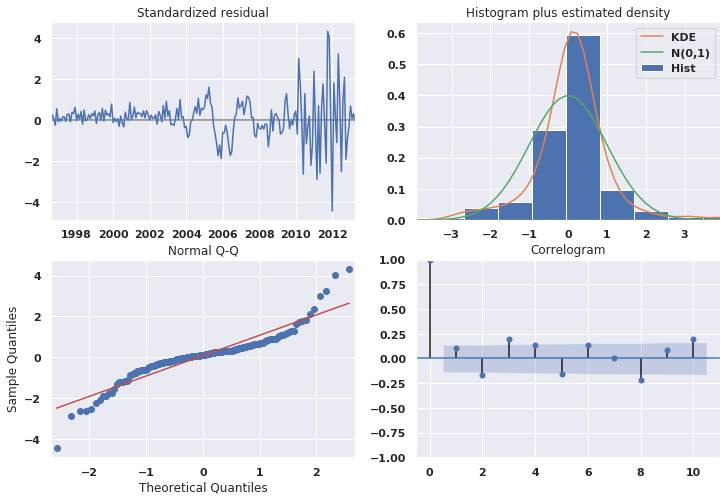

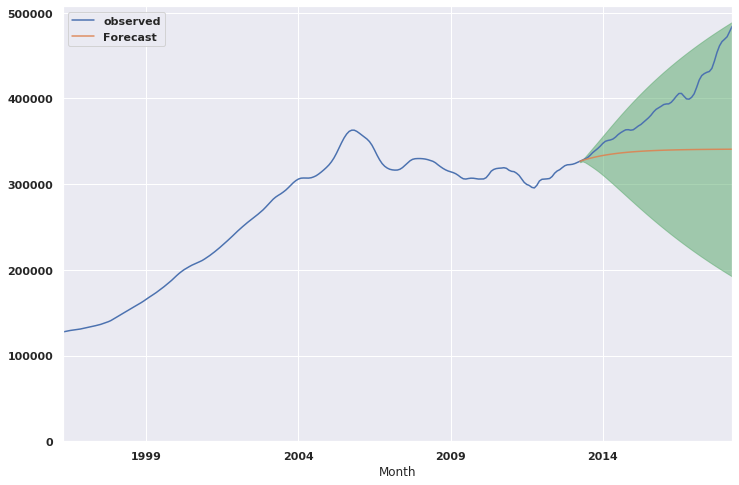

In [122]:
train_test_SARIMAX(zdf_by_zip[3801],
                   order = (3,1,0),
                   start = '2013-04-01')

#### SARIMAX Nationwide Foreccast

I'll put together a complete model including diagnostics and forecasts.

Note that I had once had a different set of numbers, including seasonal figures. I decided to get rid of the seasonal figures once I realized that although the seasonal graph shows a clear seasonal trend, the variance is so little that it isn't worth plugging in the figures.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9904      0.011     88.788      0.000       0.968       1.012
ma.L1         -0.2511      0.031     -8.219      0.000      -0.311      -0.191
sigma2      7.562e+04   1700.285     44.477      0.000    7.23e+04     7.9e+04
AIC:  3693.4514195509532


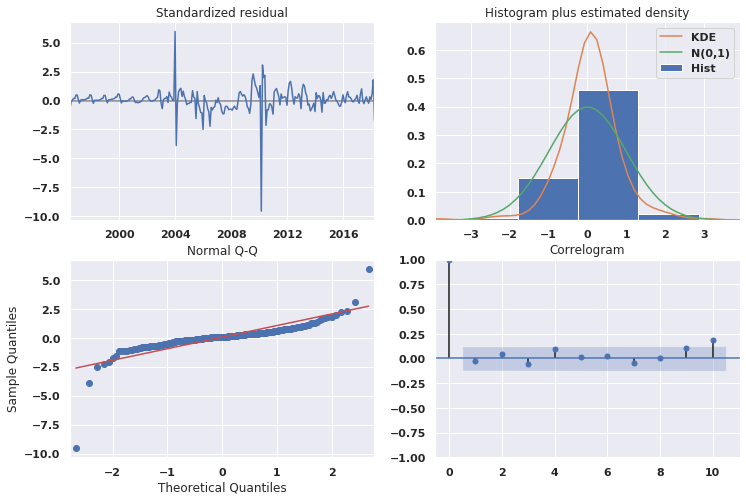

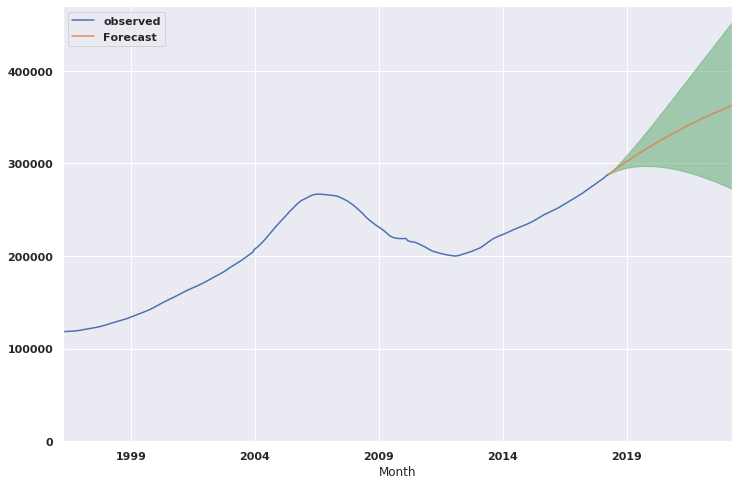

In [123]:
forecast_SARIMAX(data = zdf_by_zip['Nationwide'], 
          order = (1,1,1),
          start = '2018-04-01',
          end = '2023-04-01')

#### SARIMAX Example Forecast

Now that we have starting parameters for a nationwide model, I'll try out the model_zip function on a the same Portsmouth example from earlier.

This is going to be one of the reasons for ultimately picking ARIMA over SARIMAX for my modeling. There is something clearly wrong with the below SARIMAX model, even though order test liked this order. I specifically chose this zipcode because there's something wrong with it, to illustrate my choice of model.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6574      0.154     10.784      0.000       1.356       1.959
ar.L2         -1.3632      0.291     -4.692      0.000      -1.933      -0.794
ar.L3          0.9390      0.291      3.229      0.001       0.369       1.509
ar.L4         -0.5072      0.234     -2.167      0.030      -0.966      -0.048
ar.L5          0.0934      0.165      0.565      0.572      -0.231       0.417
ar.L6          0.2857      0.109      2.619      0.009       0.072       0.499
ar.L7         -0.1715      0.060     -2.843      0.004      -0.290      -0.053
ma.L1          0.2490      0.157      1.590      0.112      -0.058       0.556
sigma2      4.443e+05   2.69e+04     16.493      0.000    3.92e+05    4.97e+05
AIC:  4086.2678817671263


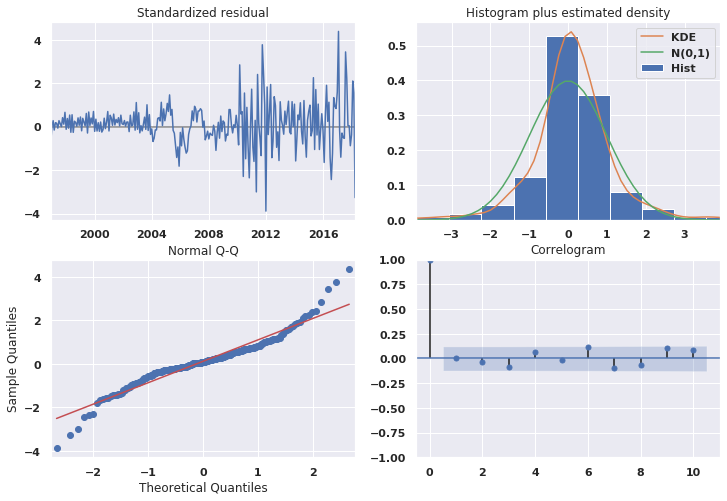

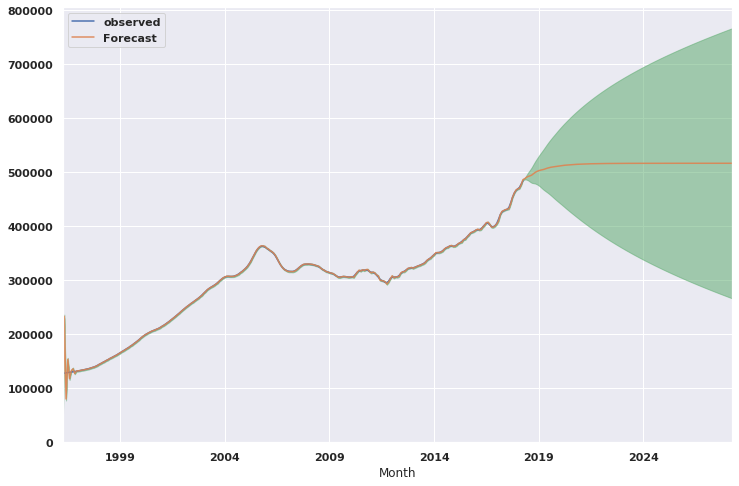

In [124]:
forecast_SARIMAX(zdf_by_zip[3801], 
          order = (7,1,1),
          start = '1996-04-01',
          end = '2028-04-01')

### ARIMA Modeling

#### ARIMA Nationwide Test

                             ARIMA Model Results                              
Dep. Variable:           D.Nationwide   No. Observations:                  204
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1454.057
Method:                       css-mle   S.D. of innovations            299.453
Date:                Sun, 12 Jan 2020   AIC                           2922.114
Time:                        21:49:42   BIC                           2945.341
Sample:                    05-01-1996   HQIC                          2931.510
                         - 04-01-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                570.9803    660.505      0.864      0.388    -723.585    1865.546
ar.L1.D.Nationwide     0.2876      0.537      0.535      0.593      -0.766       1.341
ar.L2.D.Nationwide  

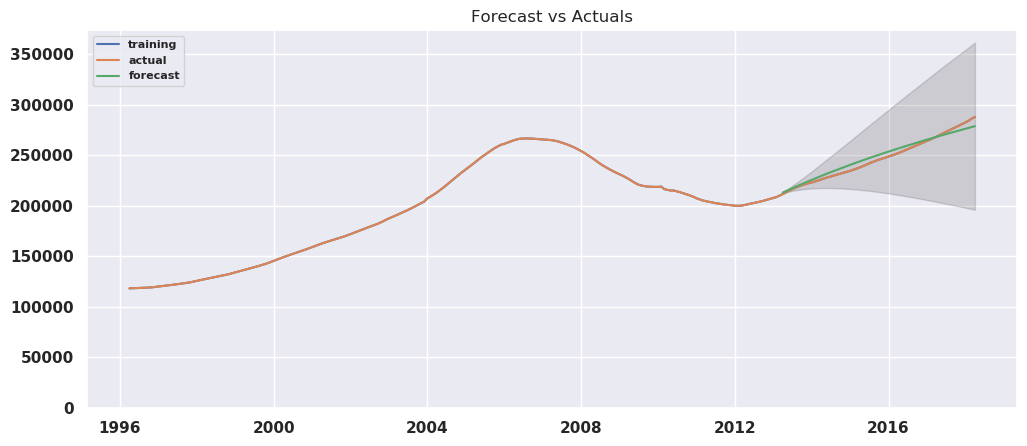

In [125]:
train_test_ARIMA(zdf_by_zip['Nationwide'], (3,1,2), start = '2013-04-01')

#### ARIMA Example Test

                             ARIMA Model Results                              
Dep. Variable:                 D.3801   No. Observations:                  204
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -1576.417
Method:                       css-mle   S.D. of innovations            544.453
Date:                Sun, 12 Jan 2020   AIC                           3166.834
Time:                        21:50:41   BIC                           3190.061
Sample:                    05-01-1996   HQIC                          3176.230
                         - 04-01-2013                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          979.2212    487.697      2.008      0.046      23.353    1935.089
ar.L1.D.3801     1.4489      0.151      9.626      0.000       1.154       1.744
ar.L2.D.3801    -0.9189      0.251     -3.66

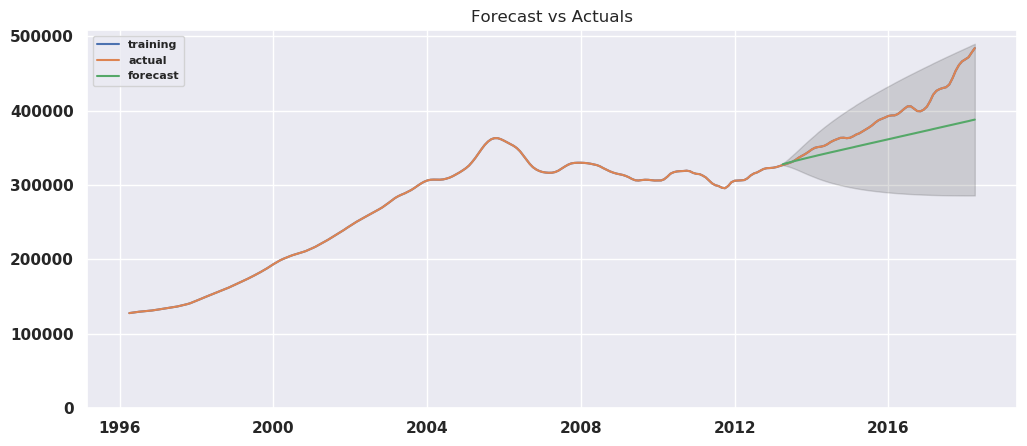

In [127]:
train_test_ARIMA(zdf_by_zip[3801], (4,1,1), start = '2013-04-01')

#### ARIMA Nationwide Forecast

In contrast to the 3801 example further up, the graph turned out differently here using an ARIMA model. For each model, I used the top order result *for that model*, so they should both be getting optimum treatment. I also tried using the same number for both, with results that were not much different. Not only did the line make more sense, but the confidence intervals are much smaller as well.

                             ARIMA Model Results                              
Dep. Variable:           D.Nationwide   No. Observations:                  264
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -1857.336
Method:                       css-mle   S.D. of innovations            273.431
Date:                Sun, 12 Jan 2020   AIC                           3724.672
Time:                        21:50:52   BIC                           3742.552
Sample:                    05-01-1996   HQIC                          3731.857
                         - 04-01-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                709.1807    569.299      1.246      0.214    -406.626    1824.987
ar.L1.D.Nationwide     0.7163      0.062     11.609      0.000       0.595       0.837
ar.L2.D.Nationwide  

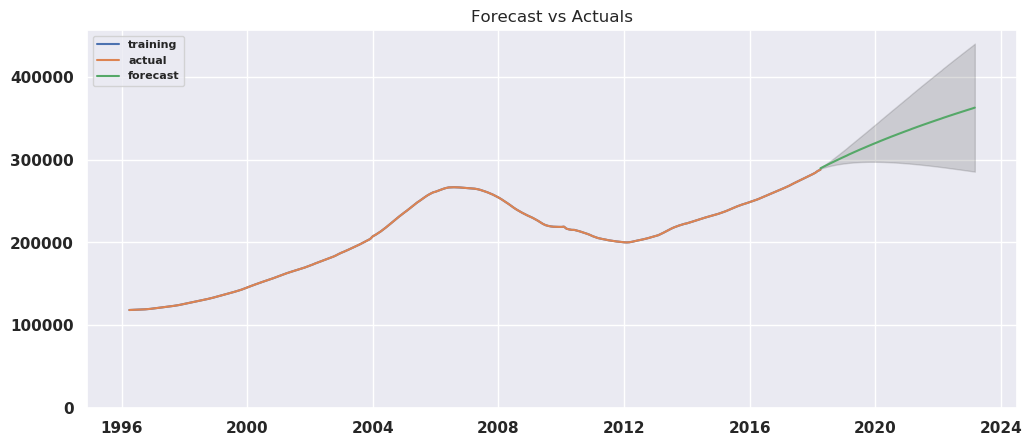

In [128]:
forecast_ARIMA(zdf_by_zip['Nationwide'], (3,1,0), forecast_length = 60)

#### ARIMA Example Forecast

                             ARIMA Model Results                              
Dep. Variable:                 D.3801   No. Observations:                  264
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -2112.640
Method:                       css-mle   S.D. of innovations            718.696
Date:                Sun, 12 Jan 2020   AIC                           4235.280
Time:                        21:50:52   BIC                           4253.160
Sample:                    05-01-1996   HQIC                          4242.465
                         - 04-01-2018                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1399.9839    509.735      2.746      0.006     400.921    2399.046
ar.L1.D.3801     1.6824      0.054     30.944      0.000       1.576       1.789
ar.L2.D.3801    -1.2383      0.090    -13.75

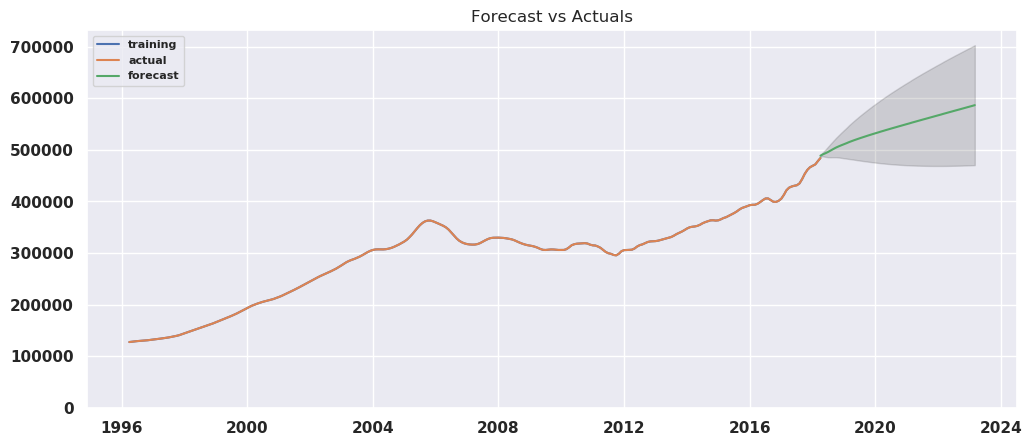

In [129]:
forecast_ARIMA(zdf_by_zip[3801], (3,1,0))

## Modeling All Zipcodes

### Creating Supplementary DataFrame

In [130]:
# Creating a basis for the columns I will want to add to the new master 
# dataframe as it is generated.
zip_info = pd.DataFrame(zdf[['RegionName', 'City', 'State', 'Metro', 
                             'CountyName', 'SizeRank']])

In [131]:
zip_info = zip_info.sort_values('RegionName')

In [132]:
zip_info.head()

,RegionName,City,State,Metro,CountyName,SizeRank
5850,1001,Agawam,MA,Springfield,Hampden,5851
4199,1002,Amherst,MA,Springfield,Hampshire,4200
11213,1005,Barre,MA,Worcester,Worcester,11214
6850,1007,Belchertown,MA,Springfield,Hampshire,6851
14547,1008,Blandford,MA,Springfield,Hampden,14548


In [133]:
zip_info.set_index(['RegionName'], inplace = True)

### Building the Model

This is the big job. I'm going to use the SARIMAX modling to create a master projection DataFrame of 1-10 year projections for every zipcode in the source.

In [134]:
# This is the blank DataFrame that all records will be concatenated to as they
# are created.
all_zip_models = pd.DataFrame()

# The following loop will cycle through every zip code, create projections out
# ten years, and build the all_zip_models DataFrame piece by piece.
# for column in zdf_by_zip.columns[1:2]:

for column in zdf_by_zip.columns:
    try:
        
        data = zdf_by_zip[column]
        # Will need a placeholder series to build the forecast against.
        ext_dates = pd.Series(range(0,120,1), 
                              index = pd.date_range('2018-04-01', 
                                                    periods = 120, 
                                                    freq = 'MS'))
        
        # ARIMA doesn't like series names to be integers, so zipcodes must be 
        # changed to strings.
        data.name = str(data.name)

        model = statsmodels.tsa.arima_model.ARIMA(data, 
                                                  order = (3,1,2))
        output = model.fit()

        # Forecast
        fc, se, conf = output.forecast(120, alpha=0.05)

        # Make as pandas series
        forecast = pd.Series(fc, index=ext_dates.index)

        # projections will house the metadata for each zip, and columns will
        # house the projection data as it is created.
        projections = [column]
        columns = ['Zip']

        # I'll be iterating 1 year at a time, beginning 1 year from the last 
        # date in the data set.
        j = 11
        columns.extend(zip_info.columns)
        columns.append('2018-04-01')

        # Continuing to add the zip metadata.
        for col_name in zip_info.columns:
            projections.append(zip_info.loc[column][col_name])

        # Defining where we will begin the forecast.
        start = zdf_by_zip.loc['2018-04-01'][column]
        projections.append(start)

        # The 10 years of projections are added one at a time. 
        # Percent Gain is also added in at this point.
        for i in range(0, 10):
            this_proj = round(forecast[j],2)
            this_gain = round((this_proj - start) / start,2)
            projections.extend([this_proj, this_gain])
            columns.extend([str(i + 1) + '_Year', str(i + 1) + '_Gain'])
            j += 12
        # Create a temporary dataframe from the data I've created to 
        # concatenate to the master DataFrame.
        temp = pd.DataFrame([projections], columns = columns)
        all_zip_models = pd.concat([all_zip_models, temp], axis = 0,
                                   ignore_index = True)
              
    except:
        continue
    

In [135]:
all_zip_models.head()

,Zip,City,State,Metro,CountyName,SizeRank,2018-04-01,1_Year,1_Gain,2_Year,2_Gain,3_Year,3_Gain,4_Year,4_Gain,5_Year,5_Gain,6_Year,6_Gain,7_Year,7_Gain,8_Year,8_Gain,9_Year,9_Gain,10_Year,10_Gain
0,1001,Agawam,MA,Springfield,Hampden,5851,223600.0,228088.51,0.02,232801.73,0.04,237536.32,0.06,242275.19,0.08,247014.92,0.10,251754.84,0.13,256494.78,0.15,261234.73,0.17,265974.69,0.19,270714.64,0.21
1,1002,Amherst,MA,Springfield,Hampshire,4200,353300.0,367524.65,0.04,376853.18,0.07,385553.82,0.09,394173.97,0.12,402783.80,0.14,411392.31,0.16,420000.64,0.19,428608.96,0.21,437217.27,0.24,445825.59,0.26
2,1005,Barre,MA,Worcester,Worcester,11214,220700.0,230173.95,0.04,236433.18,0.07,242109.93,0.10,247682.58,0.12,253236.62,0.15,258787.34,0.17,264337.47,0.20,269887.49,0.22,275437.49,0.25,280987.48,0.27
3,1007,Belchertown,MA,Springfield,Hampshire,6851,270600.0,274183.99,0.01,278811.92,0.03,283624.53,0.05,288558.55,0.07,293572.18,0.08,298638.00,0.10,303738.04,0.12,308860.52,0.14,313997.70,0.16,319144.52,0.18
4,1008,Blandford,MA,Springfield,Hampden,14548,214200.0,224633.24,0.05,231178.97,0.08,236351.25,0.10,241131.58,0.13,245799.79,0.15,250435.92,0.17,255062.86,0.19,259687.17,0.21,264310.73,0.23,268934.07,0.26


In [136]:
# Legacy SARIMAX code I don't yet have the heart to get rid of.

# # This is the blank DataFrame that all records will be concatenated to as they
# # are created.
# all_zip_models = pd.DataFrame()

# # The following loop will cycle through every zip code, create projections out
# # ten years, and build the all_zip_models DataFrame piece by piece.
# for column in zdf_by_zip.columns[1:20]:
#     # This is probably going to take about 15 hours to complete. I really don't
#     # want it to break in the middle of it for some reason.
# #     try:
        
        
        
#     # Keeping the below for legacy knowledge since this is what was used for
#     # the first run.
# #         model = sm.tsa.statespace.SARIMAX(zdf_by_zip[column], order = (1,1,2), 
# #                                       seasonal_order = (2,1,2,12),
# #                                       enforce_stationarity = False,
# #                                       enforce_invertability = False)

# #         model = sm.tsa.statespace.SARIMAX(zdf_by_zip[column]['2013-04-01':], order = (1,1,1),
# #                                       enforce_stationarity = False,
# #                                       enforce_invertability = False)
#     model = statsmodels.tsa.arima_model.ARIMA(zdf_by_zip['Nationwide'], 
#                                               order = (1,1,2))
#     output = model.fit()

#     prediction = output.predict(start = '2018-04-01', end = '2028-04-01',
#                                 dynamic = False)
#     print(prediction)
#     # We're forecasting 10 years out, but we can get data from anywhere 
#     # from 1 to 10 years afterward.

# #         prediction = output.get_prediction(start = '2018-04-01',
# #                                        end = '2028-04-01',
# #                                        dynamic = False)

#     # The below stopped working for some reason. Trying the above.
# #         prediction = output.get_forecast(steps = 120)
# #         print(prediction.predicted_mean)

#     # projections will house the metadata for each zip, and columns will
#     # house the projection data as it is created.
#     projections = [column]
#     columns = ['Zip']

#     # I'll be iterating 1 year at a time, beginning 1 year from the last 
#     # date in the data set.
#     j = 11
#     columns.extend(zip_info.columns)
#     columns.append('2018-04-01')

#     # Continuing to add the zip metadata.
#     for col_name in zip_info.columns:
#         projections.append(zip_info.loc[column][col_name])

#     # Defining where we will begin the forecast.
#     start = zdf_by_zip.loc['2018-04-01'][column]
#     projections.append(start)

#     # The 10 years of projections are added one at a time. 
#     # Percent Gain is also added in at this point.
#     for i in range(0, 10):
#         this_proj = round(prediction.predicted_mean[j],2)
#         this_gain = round((this_proj - start) / start,2)
#         projections.extend([this_proj, this_gain])
#         columns.extend([str(i + 1) + '_Year', str(i + 1) + '_Gain'])
#         j += 12
#     # Create a temporary dataframe from the data I've created to 
#     # concatenate to the master DataFrame.
#     temp = pd.DataFrame([projections], columns = columns)
#     all_zip_models = pd.concat([all_zip_models, temp], axis = 0,
#                                ignore_index = True)
        
        
        
# #     except:
# #         continue
    

Below is for when I'm running off a csv, so I don't have to re-make that dataframe every time I re-run the notebook.

In [137]:
# all_zip_models = pd.read_csv('all_zip_models.csv')

Checking to see that everything worked correctly.

In [138]:
all_zip_models.tail()

,Zip,City,State,Metro,CountyName,SizeRank,2018-04-01,1_Year,1_Gain,2_Year,2_Gain,3_Year,3_Gain,4_Year,4_Gain,5_Year,5_Gain,6_Year,6_Gain,7_Year,7_Gain,8_Year,8_Gain,9_Year,9_Gain,10_Year,10_Gain
13377,99709,Fairbanks,AK,Fairbanks,Fairbanks North Star,4527,262400.0,269682.80,0.03,277004.18,0.06,284342.71,0.08,291682.94,0.11,299023.34,0.14,306363.75,0.17,313704.17,0.20,321044.58,0.22,328385.00,0.25,335725.41,0.28
13378,99712,Fairbanks,AK,Fairbanks,Fairbanks North Star,8439,274600.0,283649.03,0.03,291280.45,0.06,298837.71,0.09,306390.90,0.12,313943.86,0.14,321496.81,0.17,329049.76,0.20,336602.70,0.23,344155.65,0.25,351708.60,0.28
13379,99801,Juneau,AK,Juneau,Juneau,4107,413300.0,421210.63,0.02,431968.79,0.05,442787.22,0.07,453607.08,0.10,464426.96,0.12,475246.85,0.15,486066.74,0.18,496886.63,0.20,507706.51,0.23,518526.40,0.25
13380,99835,Sitka,AK,NaN,Sitka,8659,404800.0,423752.51,0.05,438599.88,0.08,451343.68,0.11,463149.03,0.14,474534.24,0.17,485731.38,0.20,496844.32,0.23,507919.57,0.25,518977.94,0.28,530028.76,0.31
13381,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,7294,305100.0,327705.32,0.07,341880.40,0.12,352781.87,0.16,362557.08,0.19,371937.53,0.22,381178.30,0.25,390369.98,0.28,399544.39,0.31,408712.72,0.34,417878.91,0.37


This took like 15 hours to run. I don't want to lose it.

In [139]:
all_zip_models.to_csv('all_zip_models_312.csv')

Getting rid of null values that will mess up my DataFrame.

In [140]:
# Create a list of zipcodes with null values.
null_zips = []

for column in zdf_by_zip.columns:
    if zdf_by_zip[column].isnull().sum() > 0:
        null_zips.append(column)
        

In [141]:
# Remove everything from that list.
for zip in null_zips:
    try:
        all_zip_models.drop(all_zip_models[all_zip_models['Zip'] == zip].index,
                           inplace = True)
    except:
        continue

Check to see that the DataFrame has in fact been reduced.

In [142]:
all_zip_models.shape

(13382, 27)

Resetting the index for the sake of the loaded file.

In [143]:
# all_zip_models = all_zip_models.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis = 1)

In [144]:
all_zip_models.head()

,Zip,City,State,Metro,CountyName,SizeRank,2018-04-01,1_Year,1_Gain,2_Year,2_Gain,3_Year,3_Gain,4_Year,4_Gain,5_Year,5_Gain,6_Year,6_Gain,7_Year,7_Gain,8_Year,8_Gain,9_Year,9_Gain,10_Year,10_Gain
0,1001,Agawam,MA,Springfield,Hampden,5851,223600.0,228088.51,0.02,232801.73,0.04,237536.32,0.06,242275.19,0.08,247014.92,0.10,251754.84,0.13,256494.78,0.15,261234.73,0.17,265974.69,0.19,270714.64,0.21
1,1002,Amherst,MA,Springfield,Hampshire,4200,353300.0,367524.65,0.04,376853.18,0.07,385553.82,0.09,394173.97,0.12,402783.80,0.14,411392.31,0.16,420000.64,0.19,428608.96,0.21,437217.27,0.24,445825.59,0.26
2,1005,Barre,MA,Worcester,Worcester,11214,220700.0,230173.95,0.04,236433.18,0.07,242109.93,0.10,247682.58,0.12,253236.62,0.15,258787.34,0.17,264337.47,0.20,269887.49,0.22,275437.49,0.25,280987.48,0.27
3,1007,Belchertown,MA,Springfield,Hampshire,6851,270600.0,274183.99,0.01,278811.92,0.03,283624.53,0.05,288558.55,0.07,293572.18,0.08,298638.00,0.10,303738.04,0.12,308860.52,0.14,313997.70,0.16,319144.52,0.18
4,1008,Blandford,MA,Springfield,Hampden,14548,214200.0,224633.24,0.05,231178.97,0.08,236351.25,0.10,241131.58,0.13,245799.79,0.15,250435.92,0.17,255062.86,0.19,259687.17,0.21,264310.73,0.23,268934.07,0.26


Since that DataFrame is such a bear to create, I'll copy it before doing any damage.

In [145]:
all_zip_ranked = all_zip_models.sort_values('10_Gain', ascending = False)

Adding in a column to display each zip's overall rank.

In [146]:
all_zip_ranked['Rank'] = [i + 1 for i in range(0, len(all_zip_ranked))]

In [147]:
all_zip_ranked.head(20)

,Zip,City,State,Metro,CountyName,SizeRank,2018-04-01,1_Year,1_Gain,2_Year,2_Gain,3_Year,3_Gain,4_Year,4_Gain,5_Year,5_Gain,6_Year,6_Gain,7_Year,7_Gain,8_Year,8_Gain,9_Year,9_Gain,10_Year,10_Gain,Rank
9646,72837,Dover,AR,Russellville,Pope,9156,112000.0,154950.94,0.38,193015.50,0.72,225654.46,1.01,254604.62,1.27,279780.06,1.50,301777.18,1.69,321479.78,1.87,338310.81,2.02,353831.77,2.16,366996.56,2.28,1
4132,28208,Charlotte,NC,Charlotte,Mecklenburg,1822,113400.0,139871.29,0.23,164971.73,0.45,188240.90,0.66,209889.04,0.85,230091.94,1.03,249006.46,1.20,266772.46,1.35,283514.58,1.50,299343.95,1.64,314359.66,1.77,2
1294,8611,Trenton,NJ,Trenton,Mercer,5279,45900.0,61190.70,0.33,72278.01,0.57,80231.43,0.75,86077.15,0.88,90496.26,0.97,93929.71,1.05,96695.61,1.11,99003.77,1.16,100999.88,1.20,102782.84,1.24,3
5877,37779,Luttrell,TN,Knoxville,Union,11775,78100.0,100658.85,0.29,116737.28,0.49,128395.40,0.64,137264.98,0.76,144375.09,0.85,150375.00,0.93,155674.38,0.99,160531.75,1.06,165110.20,1.11,169512.66,1.17,4
5740,37160,Shelbyville,TN,Shelbyville,Bedford,2555,136100.0,162312.84,0.19,185251.79,0.36,204785.73,0.50,221656.15,0.63,236444.67,0.74,249605.92,0.83,261495.26,0.92,272390.42,1.00,282508.50,1.08,292019.21,1.15,5
6110,39629,Bogue Chitto,MS,Brookhaven,Lincoln,9897,132500.0,182394.46,0.38,209971.17,0.58,226779.15,0.71,238334.82,0.80,247306.79,0.87,255002.98,0.92,262069.47,0.98,268825.95,1.03,275430.25,1.08,281959.97,1.13,6
10539,78242,San Antonio,TX,San Antonio,Bexar,4610,102500.0,124864.30,0.22,142824.38,0.39,157482.51,0.54,169690.99,0.66,180082.13,0.76,189125.02,0.85,197167.68,0.92,204468.27,0.99,211218.35,1.06,217560.01,1.12,7
5470,34691,Holiday,FL,Tampa,Pasco,4020,104800.0,132138.93,0.26,152179.08,0.45,167255.37,0.60,178998.87,0.71,188504.69,0.80,196508.11,0.88,203502.81,0.94,209820.25,1.00,215682.95,1.06,221240.35,1.11,8
7238,48239,Redford,MI,Detroit,Wayne,1963,97600.0,115546.03,0.18,130804.28,0.34,143820.46,0.47,155057.51,0.59,164880.54,0.69,173579.79,0.78,181385.91,0.86,188482.20,0.93,195014.35,1.00,201098.16,1.06,9
1011,7501,Paterson,NJ,New York,Passaic,4045,187200.0,229285.43,0.22,261772.68,0.40,286619.13,0.53,306260.24,0.64,322335.02,0.72,335966.94,0.79,347925.55,0.86,358737.97,0.92,368765.26,0.97,378254.75,1.02,10


                             ARIMA Model Results                              
Dep. Variable:                D.15214   No. Observations:                  264
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -1839.122
Method:                       css-mle   S.D. of innovations            255.705
Date:                Sun, 12 Jan 2020   AIC                           3688.245
Time:                        22:55:20   BIC                           3706.124
Sample:                    05-01-1996   HQIC                          3695.429
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           210.4011     75.969      2.770      0.006      61.505     359.297
ar.L1.D.15214     1.2769      0.058     22.164      0.000       1.164       1.390
ar.L2.D.15214    -0.8618      0.083    -

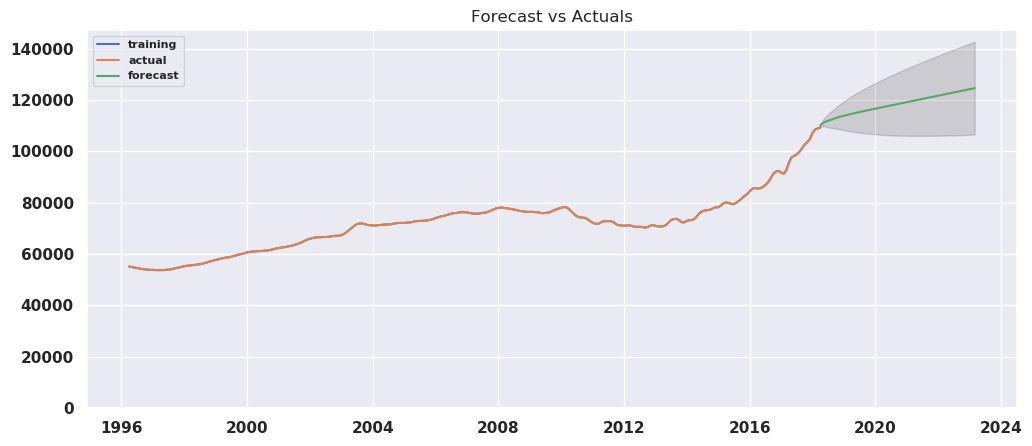

In [148]:
forecast_ARIMA(zdf_by_zip[15214], (3,1,0))

# Assessment

My goal here is going to be to drill down to the state, county, and city levels to find the top area before determining the top zip codes, in order to identify an area that is more secure in the surrounding areas.

This function will group records together as specified by either state, county, or city.

In [149]:
def group_areas(data, group = 'State', 
                years_ahead = 10):
    """Group a zipcode DataFrame in zip-wide format 
    according to state, county, or city
        
    Parameters:
        
        data (DataFrame)
            Zipcode DataFrame in zip-wide format with forecasts
            
        group (String)
            State, CountyName, or City value from zipcode dataframe.
            
        years_ahead (Int)
            1 to 10 years for forecast length.
            
    Returns:
        DataFrame with areas grouped by top precentage of gain.

    """
    forecast_len = str(years_ahead) + '_Gain'
    
    df = pd.DataFrame(data.groupby(
        group)[forecast_len].mean()).sort_values(
        forecast_len, ascending = False)

    df['Rank'] = [i + 1 for i in range(0, len(df))]
    
    return df

In [150]:
state_group = group_areas(all_zip_ranked, 'State', 10)

In [151]:
state_group

,10_Gain,Rank
State,,
CO,0.352822,1
FL,0.348638,2
SD,0.335000,3
WA,0.322485,4
OR,0.317416,5
TN,0.314167,6
HI,0.308800,7
MN,0.302560,8
DC,0.302222,9


In [152]:
state_group.index[0]

'CO'

This is the function that will be used to find the top zip codes in the specified state, as discovered by drilling into county, city, and zipcode levels.

In [153]:
def drill_for_zips(state, 
                   data=all_zip_ranked, 
                   num_results=5,
                   years_ahead=10):
    """Drills down from state through county and city levels to find the 
    top ranked zip codes by ranking of precent gain over specified years.
    
    Parameters:
    
        state (string)
            In capital abbreviated format ('CA'), specifies the state
            to investigate.
            
        data (DataFrame)
            Generally uses all_zip_ranked or another DataFrame 
            with zip codes ranked by percent gains, 1 - 5 years out.
            
        num_results (Int)
            How many results to display, ranked from the first down.
            
        years_ahead (Int)
            How many years ahead to look when searching for percent gain."""
            
    #Create df of all records in the prescribed state
    top_state_df = data[data['State'] == state]

    # create df of all counties within the specified state.
    county_df = group_areas(top_state_df, 'CountyName', years_ahead)
    
    # This will be the list of top zip codes that will be used to create the 
    # dataframe that will be returned.
#     top_zips = []
    
    top_zips = pd.DataFrame()
    
    # This will loop through the necessary data sets, drilling into each 
    # county and city until the specified number of results has been reached.
    i = 0
    while len(top_zips) < num_results:
                
        # Create a df of only the data for the top county in this state.
        # Iterates if not enough records in the first county.
        top_county_df = top_state_df[top_state_df['CountyName']
                               == county_df.index[i]]
        
        # Drilling to the city level.
        j = 0
        while len(top_zips) < num_results:
            
            # Create a grouped df that groups the zips by city.
            city_group = group_areas(top_county_df, 'City', 10)
        
            # Create a df of the data for the top city in this county.
            try:
                top_city_df = top_state_df[(top_state_df['City'] 
                                     == city_group.index[j])
                                     & (data['State']
                                     == state)]
            except:
                j = 0
                break
            
            # Interate through each zip in the 'top city' and add to top_zips.
            for a_zip in range(len(top_city_df)):
                
                if len(top_zips) <= num_results:
                    
                    # Finding the zip code for this iteration, getting the full
                    # data, and adding it to top_zips.
                    this_zip = list(top_city_df.Zip)[a_zip]
                    temp = data[data['Zip'] == this_zip]
                    top_zips = pd.concat([top_zips, temp])
            
                else:
                    break
                
            j += 1
        
        i += 1
    
    return top_zips.sort_values('10_Gain', ascending = False)


## Find the Top Cities in Each County

In [163]:
drill_for_zips('ME', num_results = 10, years_ahead = 10)

,Zip,City,State,Metro,CountyName,SizeRank,2018-04-01,1_Year,1_Gain,2_Year,2_Gain,3_Year,3_Gain,4_Year,4_Gain,5_Year,5_Gain,6_Year,6_Gain,7_Year,7_Gain,8_Year,8_Gain,9_Year,9_Gain,10_Year,10_Gain,Rank
727,4352,Mt Vernon,ME,Augusta,Kennebec,13815,178700.0,212623.87,0.19,229930.61,0.29,241208.55,0.35,250043.04,0.40,257969.80,0.44,265604.16,0.49,273144.58,0.53,280649.47,0.57,288140.05,0.61,295625.52,0.65,114
728,4355,Readfield,ME,Augusta,Kennebec,12989,157000.0,174006.92,0.11,182491.71,0.16,188778.52,0.20,194560.46,0.24,200226.72,0.28,205865.99,0.31,211499.03,0.35,217130.62,0.38,222761.88,0.42,228393.07,0.45,644
718,4259,Monmouth,ME,Augusta,Kennebec,12179,189600.0,203868.61,0.08,211825.34,0.12,218337.38,0.15,224529.26,0.18,230650.19,0.22,236755.40,0.25,242857.13,0.28,248958.08,0.31,255058.87,0.35,261159.61,0.38,1343
729,4358,China Village,ME,Augusta,Kennebec,11438,158300.0,172908.96,0.09,174432.51,0.10,178027.06,0.12,183108.53,0.16,187961.52,0.19,192645.74,0.22,197355.16,0.25,202083.73,0.28,206809.52,0.31,211533.14,0.34,2164
725,4347,Hallowell,ME,Augusta,Kennebec,12332,184300.0,195487.98,0.06,202907.56,0.10,208702.88,0.13,214029.61,0.16,219196.23,0.19,224312.13,0.22,229411.42,0.24,234505.36,0.27,239597.56,0.30,244689.19,0.33,2695
730,4364,Winthrop,ME,Augusta,Kennebec,9820,181500.0,192096.24,0.06,195464.55,0.08,200316.58,0.10,205608.16,0.13,210739.42,0.16,215850.56,0.19,220976.46,0.22,226102.57,0.25,231227.48,0.27,236352.48,0.30,3960
726,4351,Manchester,ME,Augusta,Kennebec,12703,199900.0,204740.10,0.02,208693.02,0.04,214435.42,0.07,220084.75,0.10,225546.23,0.13,231037.60,0.16,236546.58,0.18,242050.43,0.21,247552.86,0.24,253056.02,0.27,5452
723,4330,Augusta,ME,Augusta,Kennebec,3311,133900.0,138352.53,0.03,140116.84,0.05,143279.64,0.07,146422.96,0.09,149349.91,0.12,152349.55,0.14,155360.26,0.16,158355.84,0.18,161354.52,0.21,164354.61,0.23,7996
724,4345,Gardiner,ME,Augusta,Kennebec,7466,137100.0,140116.36,0.02,142255.63,0.04,145856.50,0.06,149072.40,0.09,152242.57,0.11,155474.11,0.13,158690.54,0.16,161904.70,0.18,165121.42,0.20,168337.56,0.23,7997
737,4901,Waterville,ME,Augusta,Kennebec,3771,129100.0,134027.55,0.04,135110.52,0.05,137666.14,0.07,140543.95,0.09,143258.04,0.11,145947.17,0.13,148654.00,0.15,151362.53,0.17,154069.19,0.19,156775.77,0.21,9414


                             ARIMA Model Results                              
Dep. Variable:                 D.3801   No. Observations:                  264
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -2099.344
Method:                       css-mle   S.D. of innovations            682.848
Date:                Sun, 12 Jan 2020   AIC                           4212.688
Time:                        23:11:45   BIC                           4237.720
Sample:                    05-01-1996   HQIC                          4222.746
                         - 04-01-2018                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1396.9760    500.810      2.789      0.006     415.406    2378.546
ar.L1.D.3801     1.6692      0.188      8.856      0.000       1.300       2.039
ar.L2.D.3801    -1.0989      0.211     -5.21

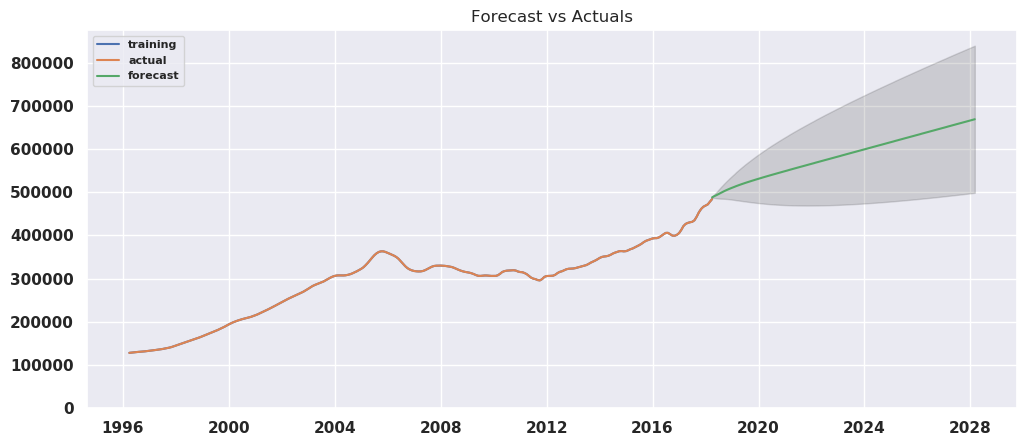

In [161]:
forecast_ARIMA(zdf_by_zip[3801], order = (3,1,2), forecast_length = 120)

# Step 6: Interpreting Results